# Longitudinal tracking simulations

S. Albright, H. Damerau, A. Lasheen, F. Tecker, C. Völlinger


## Links

- Introductory CAS wesite: https://indico.cern.ch/event/1117526/
- Programme of the CAS: https://cas.web.cern.ch/sites/default/files/Timetable_Introductory2022_ver7.pdf
- Python software installation for transverse (and longitudinal) exercises: https://github.com/cerncas/hands-on-lattice-exercises/blob/master/Setup_Instructions.md
- Longitudinal hands-on, link to content and cheat sheets: https://indico.cern.ch/event/1117526/contributions/4978478/


## Introduction

In this hands-on session we will experiment with particle tracking simulations.

The goal of the session is to write a tracking code to observe the evolution of the particles in the longitudinal phase space ($\phi$, $\Delta E$), for each turn in the machine.

The notebook is constructed with the following purpose in mind:

1. Compute basic machine parameters (the example of the CERN scSPS is taken).
2. Writing the equations of motion in the form of a python function, to track a single particle.
3. Record and observe the trajectory of a particle in the longitudinal phase space.
4. Extend the tracking code to work with many particles, acceleration, below and above transition.
5. Analyze the particle motion and compare with analytical evaluations of the bucket area, height, synchrotron frequency.
6. Observe the evolution of a bunch of particles, and simulate the injection of a bunch in a synchrotron by adjusting the RF parameters to match the bunch to the RF bucket.
7. BONUS: include more complex features like multiple RF systems, synchrotron radiation, in the tracking loop.

Along the exercises, you will be encouraged to use `support_functions`. These were designed to help you during the hands-on session by reducing the coding overhead. You can check the documentation of each function by calling `function?` in a new cell.

The available support functions are

| `support_functions.py`        |
| ----------------------------- |
| plot_phase_space_trajectory   |
| plot_phase_space_distribution |
| synchrotron_tune              |
| separatrix                    |
| run_animation                 |
| oscillation_spectrum          |
| synchrotron_tune              |


In [1]:
# In this cell we import all modules that will be required for the computation
# You can add extra imports as you progress in the exercises
# Hint: use scipy.constants for elementary charge, speed of light, mass of a proton...

import matplotlib.pyplot as plt
import numpy as np
from scipy.constants import e, c, m_p


## Basic accelerator and beam parameters

### Parameters of the Super Proton Synchrotron (SPS) at CERN

| Parameter                        |                                                                                                                                |
| -------------------------------- | ------------------------------------------------------------------------------------------------------------------------------ |
| Energy range                     | $E_\mathrm{kin} = 26\,\mathrm{GeV}...1300\,\mathrm{GeV}$                                                                       |
| Circumference                    | $2 \pi R = 6911.5\,\mathrm{m}$                                                                                                 |
| Bending radius                   | $\rho = 741.3\,\mathrm{m}$                                                                                                     |
| Transition gamma                 | $\gamma_\mathrm{tr} = 18.$                                                                                                     |
| Acceleration time                | $4\,\mathrm{s}$                                                                                                                |
| Harmonic number                  | $4620$                                                                                                                         |
| Maximum RF voltage               | $V_{\mathrm{rf}} = 15\,\mathrm{MV}$                                                                                            |
| Longitudinal emittance per bunch | $\varepsilon_\mathrm{l} = 0.6\,\mathrm{eVs}$                                                                                   |
| Maximum bucket filling factor    | $\varepsilon_\mathrm{l}/A_\mathrm{bucket} = 0.8$                                                                               |
| Total beam intensity             | $N = 1.6 \cdot 10^{14} \,\mathrm{protons}$ $(2 \times 320\mathrm{b} \times 2.5 \cdot 10^{11} \mathrm{protons}/\mathrm{bunch})$ |



maxE minE time

## Exercise 1: Compute basic machine parameters



1. Compute the following parameters at the minimum/maximum energies
   -  $E$, $p$
   -  $\beta$, $\gamma$, $T_{\mathrm{rev}}$, $f_{\mathrm{rev}}$
   -  $f_{\mathrm{rf}}$, $T_{\mathrm{rf}}$
   -  $\alpha_c$, $\eta$
2. Some reflexion and crosscheck with respect to yesterday's hands-on exercises
   - How large is the RF frequency sweep ?
   - What is the bucket length ?
   - Are we above/below transition ?

In [11]:
Ekin = 26e9  # 1.3e12

charge = 1
E0 = m_p*c**2./e
circumference = 6911.5
energy = Ekin + E0
momentum = np.sqrt(energy**2. - E0**2.)
beta = momentum/energy
gamma = energy/E0

t_rev = circumference/(beta*c)
f_rev = 1/t_rev

harmonic = 4620
voltage = 4.5e6
f_rf = harmonic*f_rev
t_rf = 1/f_rf

gamma_t = 18
alpha_c = 1/gamma_t**2.
eta = alpha_c - 1/gamma**2.

print(f"Beta:\t\t\t\t\t\t{beta}")
print(f"Gamma:\t\t\t\t\t\t{gamma}")
print(f"Revolution period:\t\t\t\t{t_rev*1e6} mus")
print(f"RF frequency:\t\t\t\t\t{f_rf/1e6} MHz")
print(f"RF period:\t\t\t\t\t{t_rf*1e9} ns")
print(f"Momentum compaction factor:\t{alpha_c}")
print(f"Phase slippage factor:\t\t\t{eta}")

Beta:						0.9993932358608412
Gamma:						28.710512044511262
Revolution period:				23.0682794443392 mus
RF frequency:					200.27501449110963 MHz
RF period:					4.993134078861298 ns
Momentum compaction factor:	0.0030864197530864196
Phase slippage factor:			0.0018732596374893458


## Exercise 2: Tracking with a single particle

1. Write functions to track the particle coordinates following longitudinal equations of motion
   $$\phi_{n+1} = \phi_n + 2 \pi h \eta \frac{\Delta E_n}{\beta^2 E}$$
   $$\Delta E_{n+1} = \Delta E_n + q V \sin (\phi_{n+1}) - U_0$$
   - *Start with no acceleration or synchrotron radiation*
2. Define the initial coordinates of a particle in the $(\phi, \Delta E)$ phase space.
3. Simulate the evolution of the particle coordintates for few hundred turns and store the coordinates.
   - *You can pre-allocate a numpy array with `np.zeros(n_turns)` and fill the particle coordinates each turn*
   - *You can store the particle coordinates at each turn by appending the coordinates to a list*
4. Plot the evolution of the particle phase and energy vs. turn number, and the particle motion in longitudinal phase space
   - *The support function `plot_phase_space_trajectory` can be used*

In [88]:
def track(n_turns=10, phi0=0.5, dE0=0.5, U=0):
    tarr = []
    phi_n = phi0
    dE_n = dE0
    for turn in range(n_turns):
        phi_np1 = phi_n + 2*np.pi*harmonic*eta*(dE_n / (beta**2. * energy))
        dE_np1 = dE_n + charge*voltage*np.sin(phi_np1) - U
        tarr.append([phi_np1, dE_np1])
        phi_n = phi_np1
        dE_n = dE_np1
    return [r[0] for r in tarr], [r[1] for r in tarr]

In [80]:
phi_tracking_arr, dE_tracking_arr = track(n_turns=1000, phi0=0.5, dE0=0.5)

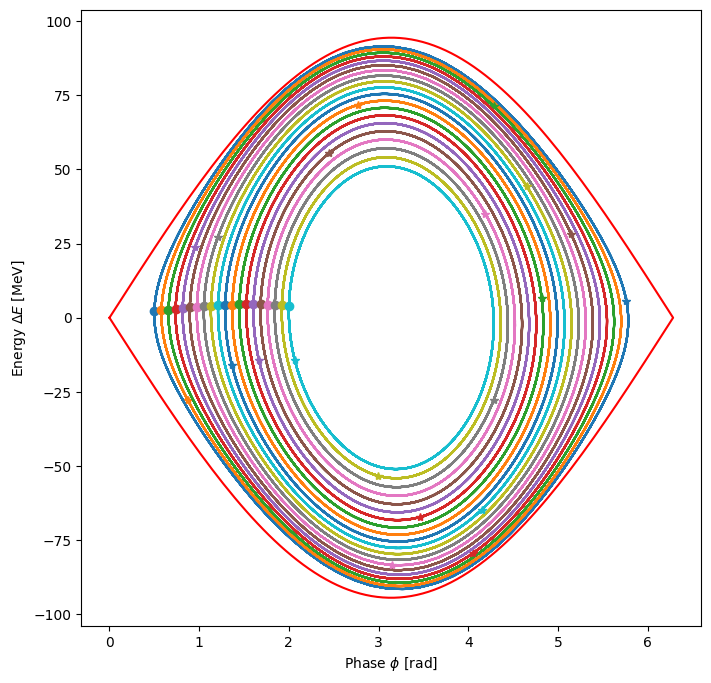

In [152]:
from support_functions import plot_phase_space_trajectory, separatrix
phi_sep, sep_arr = separatrix(np.linspace(0, np.pi*2, 100), f_rev, eta, beta, energy, charge, voltage, harmonic, 0)
plot_phase_space_trajectory(phi_tracking_arr, dE_tracking_arr, phi_sep, sep_arr)

## Exercise 3: Track with a few particles at different amplitudes

1. Repeat the same operations as in Exercise 2, starting with several particles
    - *You can simply add more particles with different variable names*
    - *You can generate numpy arrays representing several particles as `np.array([phase_1, phase_2, phase_3])`*
    - *You can store the trajectories of the particles in a pre-allocated array of size `np.zeros((n_turns, n_particles))`*
2. Track the evolution of particles including with large offsets in $\phi$ and $\Delta E$
    - *What happens when particles are too far from the synchronous particle?*
3. Generate about 10 particles at $\Delta E=0$ with different phases, and simulate for a few turns
    - *You can use `np.linspace(phase_start, phase_end, n_particles)` to linearly space particles in phase*
    - *What can you observe regarding the velocity of the particles in phase space, vs. the maximum amplitude in phase?*
4. Plot the separatrix on top of your plot
    - *Use the `separatrix` support_function to generate the separatrix.*
    - *You can pass the separatrix to the `plot_phase_space_trajectory` to combine plots*

In [141]:
def acc(initial=26e9, final=1.3e12, ramp_time=4):
    energy_ramp = final - initial
    return energy_ramp / ramp_time / (ramp_time/t_rev)

acc()

1836811.7507555087

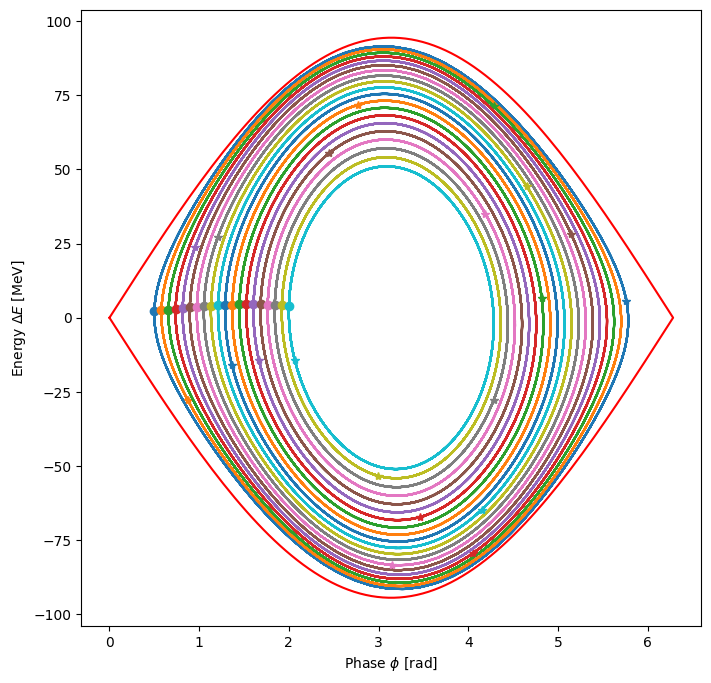

In [151]:
phis = np.linspace(0.5, 2, 20)
dEs = np.linspace(0, 0, 20)
phi_tracking_arr, dE_tracking_arr = track(n_turns=1000, phi0=phis, dE0=dEs)
phi_sep, sep_arr = separatrix(np.linspace(0, np.pi*2, 100), f_rev, eta, beta, energy, charge, voltage, harmonic, 0)
plot_phase_space_trajectory(phi_tracking_arr, dE_tracking_arr, phi_sep, sep_arr)

## Exercise 4: Acceleration

1. Track the particles by adding the acceleration term, which can be evaluated from the parameter table above
    - *For simplicity we will neglect here the variations in $\beta$, $\gamma$, $T$, $\omega$...*
2. What is the influence on the particle trajectories ?
    - *You can repeat the same tests as in the previous exercises.*
3. What happens if the ramp rate is twice as fast? Or the voltage is halved?
4. What happens if the beam is decelerated instead?

/home/ash/cas/cas-hands-on/support_functions.py:236: RuntimeWarning: invalid value encountered in sqrt
  separatrix_array = np.sqrt(


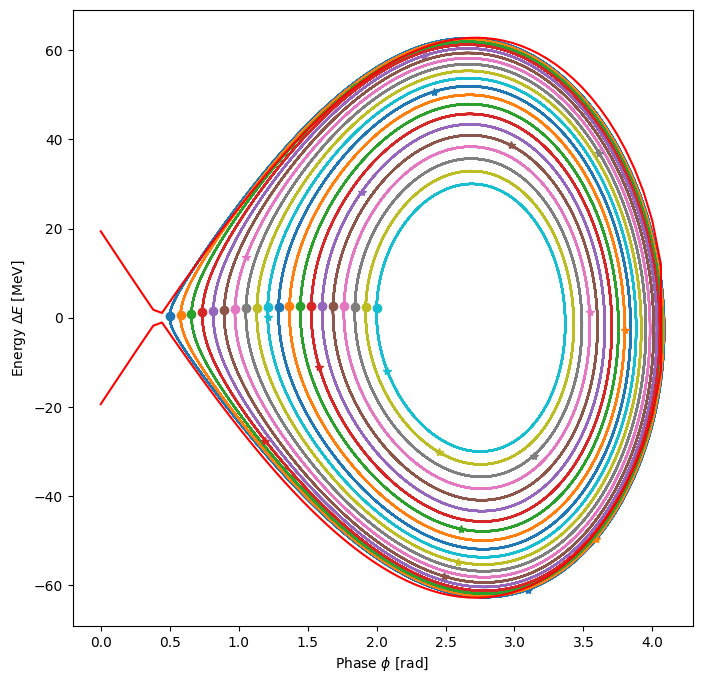

In [144]:
phi_tracking_arr, dE_tracking_arr = track(n_turns=1000, phi0=phis, dE0=dEs, U=acc())

phi_sep, sep_arr = separatrix(np.linspace(0, np.pi*2, 100), f_rev, eta, beta, energy, charge, voltage, harmonic, acc())

plot_phase_space_trajectory(phi_tracking_arr, dE_tracking_arr, phi_sep, sep_arr, figname="standard acceleration")

/home/ash/cas/cas-hands-on/support_functions.py:236: RuntimeWarning: invalid value encountered in sqrt
  separatrix_array = np.sqrt(


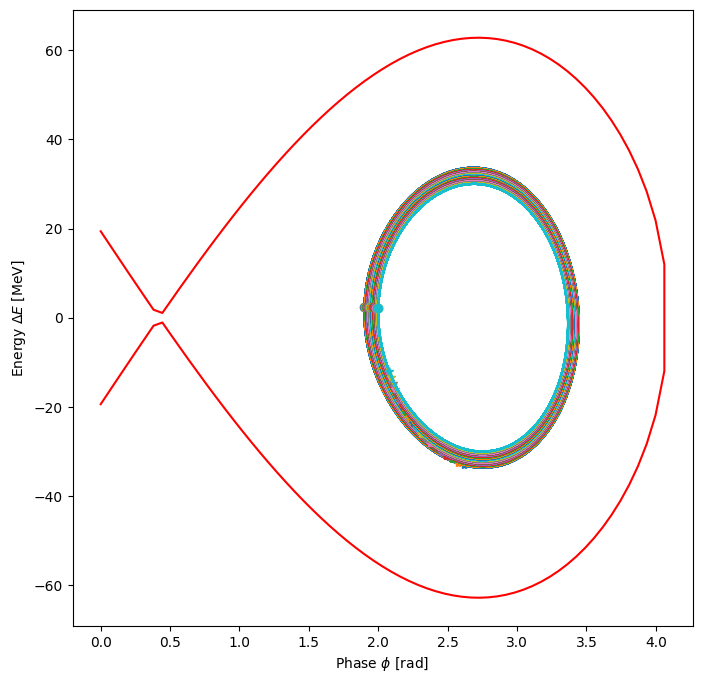

In [158]:
# FASTER RAMP
phi_tracking_arr, dE_tracking_arr = track(n_turns=1000, phi0=np.linspace(1.9, 2, 20), dE0=np.linspace(0, 0, 20), U=acc(ramp_time=4))
phi_sep, sep_arr = separatrix(np.linspace(0, np.pi*2, 100), f_rev, eta, beta, energy, charge, voltage, harmonic, acc(ramp_time=4))
plot_phase_space_trajectory(phi_tracking_arr, dE_tracking_arr, phi_sep, sep_arr, figname="half ramp time acceleration")


## Exercise 5: On the other side of transition energy

1. What if the injection kinetic energy was 14 GeV instead of 26 GeV?
2. What does that change for the bucket and why?

/home/ash/cas/cas-hands-on/support_functions.py:236: RuntimeWarning: invalid value encountered in sqrt
  separatrix_array = np.sqrt(


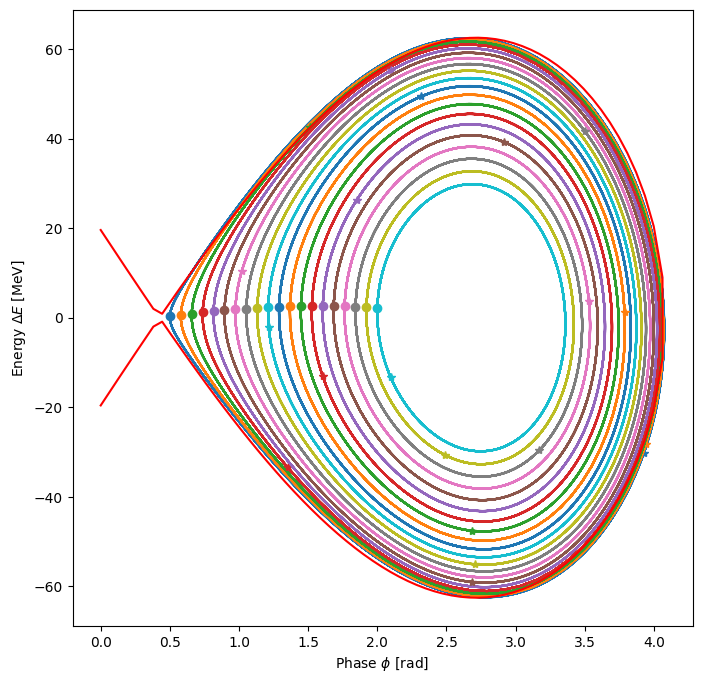

In [159]:
phi_tracking_arr, dE_tracking_arr = track(n_turns=1000, phi0=phis, dE0=dEs, U=acc(initial=14e9))
phi_sep, sep_arr = separatrix(np.linspace(0, np.pi*2, 100), f_rev, eta, beta, energy, charge, voltage, harmonic, acc(initial=14e9))
plot_phase_space_trajectory(phi_tracking_arr, dE_tracking_arr, phi_sep, sep_arr, figname="higher intiial voltage")

## Exercise 6: Comparison with analytical evaluations

1. Calculate the height and area of the stationary bucket analytically for lower/higher beam energies.
2. Determine analytically the synchrotron frequency at the centre of the stationary bucket.
3. Compare qualitatively the results you obtained with the tracking
   - *These analytical calculations serve to benchmark the tracking simulations.*

## Exercise 7: Mismatched distribution, bunch rotation

1. Generate a bunch distribution using the `generate_bunch` function.
    - *Use the `plot_phase_space_distribution` to plot the distribution in phase space*
    - *Use your tracking routine to see the bunch distribution before/after tracking*
    - *Use the `run_animation` function to monitor the evolution of the distribution while tracking*
    - *For the `run_animation` please call if you have trouble with the function syntax*
2. Try to match the bunch to the bucket. Track it for many synchrotron periods.
3. Introduce a phase or energy error between bunch and bucket.
4. Introduce a voltage mismatch. What do you observe?


## Exercise 8: Non-linear synchrotron frequency distribution, comparison with analytical formula

1. Track a few tens of particles for a few synchrotron periods to analyze the frequency of synchrotron oscillation.
   - *You can start with the same script as in Exercise 3 to start with few particles.*
   - *The function `oscillation_spectrum` returns the spectrum of phase or energy oscillations for a given particle.*
   - *The function `synchrotron_tune` returns the tune of a given particle, based on the maximum of the oscillation spectrum obtained with FFT.*
2. Plot the synchrotron frequency versus phase or energy offset. This illustrates the synchrotron frequency distribution.
   - *Beware of particles extremely close to the center of the bucket or exactly on the separatrix*
3. Compare with the expected depedence of the non-linear synchrotron tune from the cheat sheet.


## Exercises, to infinity and beyond...

- Include synchrotron radiation at 1.3 TeV
- Add second harmonic RF system in the tracking
- What happens when operating both RF systems in phase (bunch-shortening) or in counterphase (bunch-lengthening)?
- Check the effect on the synchrotron frequency.
- Animate the evolution of the bunch distribution for the test cases of exercise 9.
